Text(0.5, 1.0, 'by hour')

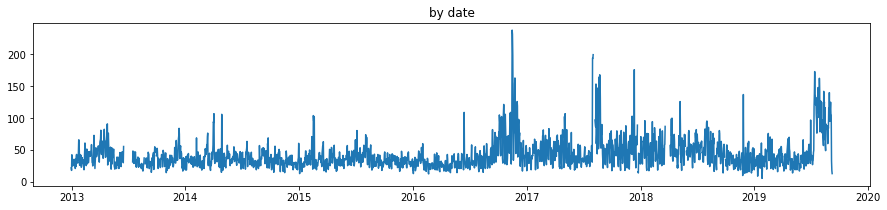

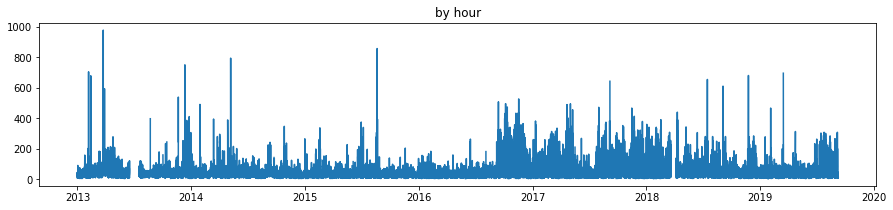

In [11]:
# load JSON
import json
import pandas as pd
 
# hourly data 
data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-PM10.pkl')
data = data.sort_values(by=['ds'])
data['just_date'] = data['ds'].dt.date
df_h = data#[0:10000]

# group by date
data_d = data.groupby(['just_date'],squeeze=True).median()
data_d.columns = ['_'.join(col).strip() for col in data_d.columns.values]
data_d = data_d.reset_index()
data_d.columns = ['ds','y'] # rename column
df_d = data_d#[0:2000]

import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.plot(df_d['ds'],df_d['y'])
plt.title('by date')
#plt.xlim('2016-06-30','2017-03-03')
plt.figure(figsize=(15,3))
plt.plot(df_h['ds'],df_h['y'])
plt.title('by hour')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


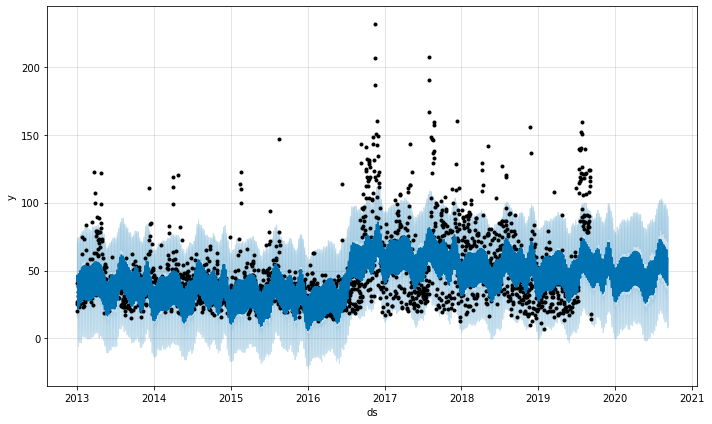

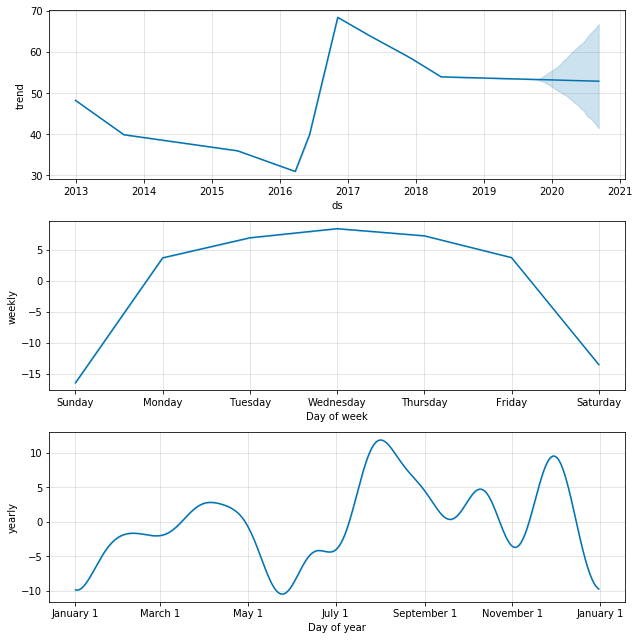

In [4]:
df = df_d # select daily or hourly daya

from fbprophet import Prophet

m = Prophet(changepoint_prior_scale=0.1) #  Increasing scale will make the trend more flexible:
m.fit(df)
future = m.make_future_dataframe(periods=365, freq='D')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
fig = m.plot(forecast)
components_fig = m.plot_components(forecast)

In [3]:
# PROPHET validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='1200 days', period='180 days', horizon ='365 days') # horizon: forecast ; initial: training (default: 3x horizon); 
df_cv.head()

INFO:fbprophet:Making 3 forecasts with cutoffs between 2016-06-27 00:00:00 and 2017-06-22 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-06-28,35.578034,18.211408,52.074268,31.541667,2016-06-27
1,2016-06-29,37.657961,20.334056,54.991981,29.708333,2016-06-27
2,2016-06-30,37.817303,21.179884,54.226563,34.521739,2016-06-27
3,2016-07-01,34.850576,17.840361,52.048262,28.727273,2016-06-27
4,2016-07-02,24.182783,7.304384,40.959793,20.625000,2016-06-27


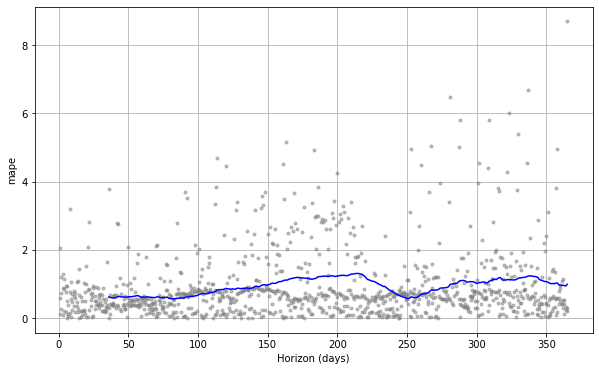

In [4]:
# Performance metrics
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

# mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE)
# computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff).
# By default, 10% of the predictions in each window (can be changed) 
# high rollingwindow --> smoother average curve 

# Visualize cross-validation
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')


In [5]:
# Percentage errors
mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
print('MAPE = ' + str(mape) + '%')
print('SMAPE = ' + str(smape) + '%')

MAPE = 91.4134793473747%
SMAPE = 16.904150541537845%


In [6]:
#import pickle
#pkl_path = "franklin-d-roosevelt/PM10_m.pkl"
#with open(pkl_path, "wb") as f:
#    # Pickle the 'Prophet' model using the highest protocol available.
#    pickle.dump(m, f)

## save the dataframe
#forecast.to_pickle("franklin-d-roosevelt/PM10_forecast.pkl")
#print("*** Data Saved ***")

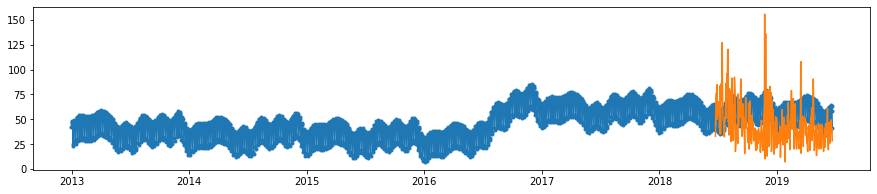

In [7]:
plt.figure(figsize=(15,3))
plt.plot(forecast.ds,forecast.yhat,marker='.')
#plt.figure(figsize=(15,3))
plt.plot(data_d.ds[2001:2365],data_d.y[2001:2365])